In [1]:
import tensorflow as tf
import loads, model
import matplotlib.pyplot as plt

In [2]:
video = loads.load_video('videos/test_video.mp4')

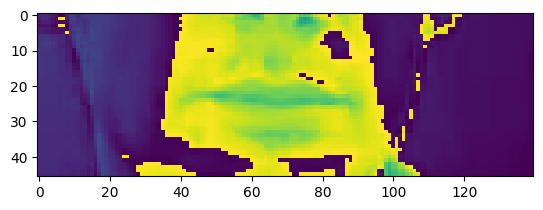

In [3]:
plt.imshow(video[0])

In [4]:
DLmodel = model.load_model()

In [5]:
yhat = DLmodel.predict(tf.expand_dims(video, axis=0))

1/1 [==============================] - 6s 6s/step


In [6]:
decoder = tf.keras.backend.ctc_decode(yhat, [29] ,greedy=True)[0][0].numpy()

In [7]:
tf.strings.reduce_join(loads.num_to_char(decoder)).numpy().decode('utf-8')

'place white by y seve'